In [24]:
from os.path import join

from omegaconf import OmegaConf
from itertools import product

import pandas as pd
from common import rmse_fn, msll_fn

import seaborn as sns
import matplotlib.pyplot as plt

In [25]:
cfg = OmegaConf.load("config/config.yaml")
configs = [{"RF": {"n_estimators": 1000, "random_state": 0}}, 
           {"GB": {"n_estimators": 1000, "random_state": 0}},
           {"GP": {"kernel": "RBFKernel", "matern_nu": 1.5, "random_state": 0, "lr": 0.1, "epochs": 20, "log_gap": 10}},
           ]

results = pd.DataFrame(columns=["model", "seed", "fold", "rmse", "msll"]).set_index(["model", "seed", "fold"])
for model_dict in configs:
    model_name = list(model_dict.keys())[0]
    model_hparams = model_dict[model_name]
    for seed_fold in product(range(cfg.common.n_seeds), range(cfg.common.n_folds)):
        seed, fold = seed_fold
        model_name_path = model_name
        cfg["common"]["seed"] = seed
        cfg["common"]["fold"] = fold
        common_config_path = "_".join(
            [f"{k}={v}" for k, v in sorted(cfg.common.items())]
        )
        model_config_path = "_".join(
            [f"{k}={v}" for k, v in sorted(model_hparams.items())]
        )
        save_dir = join(
            "artifacts", model_name_path, common_config_path, model_config_path
        )
        path = join(save_dir, "test.csv")
        
        df = pd.read_csv(path)
        df = df.dropna(subset=[cfg.common.target])
        results.loc[(model_name, seed, fold), list(model_hparams.keys())] = list(model_hparams.values())
        results.loc[(model_name, seed, fold), "rmse"] = rmse_fn(df[cfg.common.target], df[f"pred_{cfg.common.target}"])  
        results.loc[(model_name, seed, fold), "msll"] = msll_fn(df[cfg.common.target], df[f"pred_{cfg.common.target}"], df[f"pred_std_{cfg.common.target}"])
results

FileNotFoundError: [Errno 2] No such file or directory: "artifacts/GP/end_date=2022-01-31_features=['longitude', 'latitude', 'time']_fold=1_n_folds=4_n_seeds=3_seed=0_start_date=2022-01-01_target=PM2.5/epochs=20_kernel=RBFKernel_log_gap=10_lr=0.1_matern_nu=1.5_random_state=0/test.csv"

## Comparison plot

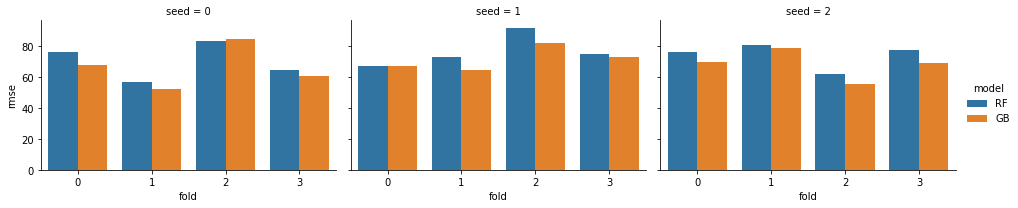

In [23]:
# plot joint bar plot of rmse and msll for all models present in results for each fold and seed
sns.catplot(data=results.reset_index(), x="fold", y="rmse", hue="model", col="seed", kind="bar", height=3, aspect=1.5);